In [1]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 5.3 MB/s 


In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
import random as rn
import imgaug.augmenters as iaa
from segmentation_models.metrics import iou_score

Segmentation Models: using `tf.keras` framework.


In [3]:
!gdown --id 1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ

Downloading...
From: https://drive.google.com/uc?id=1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ
To: /content/data.zip
2.34GB [00:26, 88.5MB/s]


In [4]:
os.listdir()

['.config', 'data.zip', 'sample_data']

In [5]:
!unzip "data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

<pre>

<h3>Structure of data folder</h3>

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....


Each image corresponds to a json file which contains the masking information such as polygons and labels for each polygon
</pre>

In [6]:
def return_file_names_df(root_dir):
    # we will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    scenes = sorted(os.listdir(os.path.join(root_dir,'images')))
    image = []
    json = []
    for folder in scenes:
      paths1 = sorted(os.listdir(os.path.join(root_dir,'images',folder)))
      for p in paths1:
        image.append(os.path.join(root_dir,'images',folder,p))
      paths2 = sorted(os.listdir(os.path.join(root_dir,'mask',folder)))
      for p in paths2:
        json.append(os.path.join(root_dir,'mask',folder,p))

    dic = {'image':image,'json':json}
    data_df=pd.DataFrame.from_dict(dic)
    return data_df

In [7]:
data_df = return_file_names_df('data')
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


In [8]:
data_df.shape

(4008, 2)

### Structure of json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File has 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

In [9]:
def return_unique_labels(data_df):
    labels = []
    for row in tqdm(data_df.json.values):
        data = pd.read_json(row)
        for lb in data.objects.values:
            labels.append(lb['label'])
    unique_labels = set(labels)
    return unique_labels

In [10]:
unique_labels = return_unique_labels(data_df)

100%|██████████| 4008/4008 [00:45<00:00, 88.49it/s] 


In [11]:
for i in unique_labels:
  print(i)

bus
curb
vehicle fallback
road
truck
ground
wall
bridge
animal
rider
bicycle
motorcycle
obs-str-bar-fallback
traffic light
car
out of roi
trailer
drivable fallback
ego vehicle
pole
rail track
tunnel
unlabeled
billboard
traffic sign
rectification border
sidewalk
fallback background
non-drivable fallback
sky
vegetation
parking
polegroup
building
autorickshaw
caravan
fence
train
guard rail
person


In [ ]:
# we have 40 different different labels we will convert them to 21 such as person and animal to one category

In [12]:
 label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}




* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before we pass it to the models, we will need to devide the image array /10.


In [13]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    data = pd.read_json(file)
    w , h = data.imgWidth.values[0] , data.imgHeight.values[0]
    label , vertexlist = [] , []
    for i in range(data.shape[0]):
        label.append(data.objects.values[i]['label'])
        polygon = data.objects.values[i]['polygon']
        if len(polygon)>1:
            vertexlist.append([tuple(i) for i in polygon ])
        else:
            pass
    return w, h, label, vertexlist

We will make image segmentation files from json file 
The mask image will look like below 

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

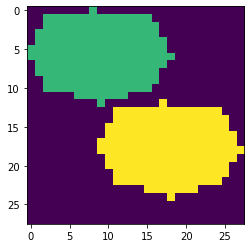

In [14]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [15]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    output_img = []
    for file_ in tqdm(data_df.json.values):
        w, h, label, vertexlist = get_poly(file_) 
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for i in range(len(vertexlist)):
            img1.polygon(vertexlist[i], fill = label_clr[label[i]])
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        path_to_save = "data/output/"+file_.split('/')[2]+"/"+file_.split('/')[-1].split('.')[0]+'.png'
        im.save(path_to_save)
        output_img.append(path_to_save)
    data_df['mask'] = output_img 
    len(output_img)
    return data_df

In [16]:
for i in os.listdir('data/images'):
  os.makedirs('data/output/'+i)
data_df = compute_masks(data_df)

100%|██████████| 4008/4008 [04:51<00:00, 13.76it/s]


In [17]:
data_df.head()

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


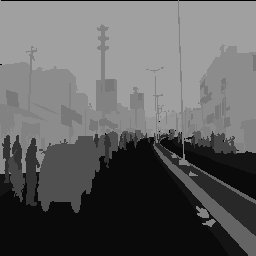

In [18]:
# let us view an image
from google.colab.patches import cv2_imshow
def view_image(file_name):
    my_img = cv2.imread(file_name) 
    my_img = cv2.resize(my_img, (256, 256), interpolation=cv2.INTER_NEAREST)  
    cv2_imshow(my_img)
view_image('data/output/201/frame0029_gtFine_polygons.png')

In [19]:
# creating some augmentation objects
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [20]:
# building custom data loaders
class Dataset:
    def __init__(self, data_df):
        
        self.images_fps   = data_df['image'].values
        self.masks_fps    = data_df['mask'].values
        self.class_values = list(set(label_clr.values()))
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256,256), interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        #mask = mask[:,:,0]
        
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        
        a = np.random.uniform()
        if a<0.33:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.66:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        else:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [21]:
X_train, X_test = train_test_split(data_df, test_size=0.12, random_state=42)

train_dataset = Dataset(X_train)
test_dataset  = Dataset(X_test)

train_dataloader = Dataloder(train_dataset, batch_size=16, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [22]:
X_train.columns

Index(['image', 'json', 'mask'], dtype='object')

## Writing custom layers

In [23]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv block"):
        super().__init__(convolutional_block)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        
        self.conv_1 = Conv2D(self.F1,(1,1),strides=(self.stride,self.stride),padding='same')
        self.conv_2 = Conv2D(self.F2,(self.kernel,self.kernel),strides=(1,1),padding='same')
        self.conv_3 = Conv2D(self.F3,(1,1),strides=(1,1),padding='same')
        self.conv_4 = Conv2D(self.F3,(self.kernel,self.kernel),strides=(self.stride,self.stride),padding='same')
        
        self.bn1 = BatchNormalization(axis=3)
        self.bn2 = BatchNormalization(axis=3)
        self.bn3 = BatchNormalization(axis=3)
        self.bn4 = BatchNormalization(axis=3)
        
        self.activation = Activation("relu")
        
        self.add = Add()
        
    def call(self, X):
        # write the architecutre that was mentioned above
        
        X_input = X
        
        # First Convolutional Block
        
        conv1 = self.conv_1(X)
        bn1 = self.bn1(conv1)
        act1 = self.activation(bn1)
        
        # Second Convolutional Block
        
        conv2 = self.conv_2(act1)
        bn2 = self.bn2(conv2)
        act2 = self.activation(bn2)
        
        # Third Convolutional Block
        
        conv3 = self.conv_3(act2)
        bn3 = self.bn3(conv3)
        
        # Adjusting the input
        
        X_input = self.conv_4(X_input)
        X_input = self.bn4(X_input)
        X_input = self.activation(X_input)
        
        # Re-add the input
        
        X = self.add([bn3, X_input])
        X = self.activation(X)
        
        return X

In [24]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity block"):
        super().__init__(identity_block)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        
        self.conv_1 = Conv2D(self.F1, (1,1), (1,1), padding="same")
        self.conv_2 = Conv2D(self.F2, (self.kernel,self.kernel), (1,1), padding="same")
        self.conv_3 = Conv2D(self.F3, (1,1), (1,1), padding="same")
        
        self.bn1 = BatchNormalization(axis=3)
        self.bn2 = BatchNormalization(axis=3)
        self.bn3 = BatchNormalization(axis=3)
        
        self.activation = Activation("relu")
        
        self.add = Add()
        
        
    def call(self, X):
        # write the architecutre that was mentioned above
        
        X_input = X
        
        conv1 = self.conv_1(X)
        bn1 = self.bn1(conv1)
        act1 = self.activation(bn1)
        
        conv2 = self.conv_2(act1)
        bn2 = self.bn2(conv2)
        act2 = self.activation(bn2)
        
        conv3 = self.conv_3(act2)
        bn3 = self.bn3(conv3)
        
        X = self.add([bn3, X_input])
        X = self.activation(X)
        
        
        return X

In [25]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, channels, name="global_flow"):
        super().__init__(global_flow)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.channels = channels
        
        self.conv1 = Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same')
        self.global_avg_pool = GlobalAveragePooling2D()
        self.bn = BatchNormalization(axis=3)
        self.activation = Activation("relu")
        self.upsample = UpSampling2D(size=(self.input_dim,self.output_dim),interpolation='bilinear')
        
    def call(self, X):
        # implement the global flow operatiom
        
        global_avg = self.global_avg_pool(X)
        
        global_avg= tf.expand_dims(global_avg, 1)
        global_avg = tf.expand_dims(global_avg, 1)
        
        bn1 = self.bn(global_avg)
        act1 = self.activation(bn1)
        
        conv1 = self.conv1(act1)
        
        X = self.upsample(conv1)
        
        return X

In [26]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(context_flow)
        
        self.conv_1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")
        self.conv_2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")
        self.conv_3 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")
        self.conv_4 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")
        
        self.concatenate = Concatenate()
        
        self.avg_pool = AveragePooling2D(pool_size=(2,2))
        
        self.activation_relu = Activation("relu")
        self.activation_sigmoid = Activation("sigmoid")
        
        self.add = Add()
        self.multiply = Multiply()
        
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear') 
        
        
    def call(self, X):        
        
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        
        # implement the context flow as mentioned in the above cell      
        
        # Context Fusion Module
        
        concat = self.concatenate([INP, FLOW])
        avg_pooling = self.avg_pool(concat)
        conv1 = self.conv_1(avg_pooling)
        conv2 = self.conv_2(conv1)
        
        # Context Refinement Module
        
        conv3 = self.conv_3(conv2)
        act1 = self.activation_relu(conv3)
        conv4 = self.conv_4(act1)
        act2 = self.activation_sigmoid(conv4)
        
        # Combining and upsampling
        
        multi = self.multiply([conv2, act2])
        add = self.add([conv2, multi])
        X = self.upsample(add)
        
        return X

In [27]:
class fsm(tf.keras.layers.Layer):
    def __init__(self, name="feature_selection"):
        super().__init__(fsm)
        
        self.conv_1 = Conv2D(32, (3,3), (1,1), padding="same")
        self.global_avg_pool = GlobalAveragePooling2D()
        self.conv_2 = Conv2D(32 ,kernel_size=(1,1),padding='same')
        self.bn = BatchNormalization()
        self.act_sigmoid = Activation('sigmoid')
        self.multiply = Multiply()
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')
        
    def call(self, X):
        
        X = self.conv_1(X)
        global_avg = self.global_avg_pool(X)
        global_avg= tf.expand_dims(global_avg, 1)
        global_avg = tf.expand_dims(global_avg, 1)
        conv1= self.conv_2(global_avg)
        bn1= self.bn(conv1)
        Y = self.act_sigmoid(bn1)
        output = self.multiply([X, Y])
        FSM_Conv_T = self.upsample(output)
        
        return FSM_Conv_T

In [28]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(agcn)
        self.conv_1  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv_2  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv_3  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv_4  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv_5  = Conv2D(32,kernel_size=(3,3),padding='same')
        self.add = Add()
        
    def call(self, X):
        # please implement the above mentioned architecture
        conv1 = self.conv_1(X)
        conv2= self.conv_2(conv1)
        
        # side path
        conv3 = self.conv_4(X)
        conv4 = self.conv_3(conv3)
        
        add1 = self.add([conv2,conv4])
        
        conv5 = self.conv_5(add1)
        
        X = self.add([conv5,add1])
        
        return X

In [33]:
X_input = Input(shape=(256,256,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)

# First Convolutional Block

c1 = convolutional_block(kernel=3,  filters=[4,4,8], stride=2)(X)
print("C1 Shape = ", c1.shape)

I11 = identity_block()(c1)
print("I11 Shape = ", I11.shape)

# Second Convolutional Block

c2 = convolutional_block(kernel=3,  filters=[8,8,16], stride=2)(I11)
print("C2 Shape = ", c2.shape)

I21 = identity_block(kernel=3,  filters=[8,8,16])(c2)
print("I21 Shape = ", I21.shape)

I22 = identity_block(kernel=3,  filters=[8,8,16])(I21)
print("I22 Shape = ", I22.shape)

# Third Convolutional Block

c3 = convolutional_block(kernel=3,  filters=[16,16,32], stride=1)(I22)
print("C3 Shape = ", c3.shape)

I31 = identity_block(kernel=3,  filters=[16,16,32])(c3)
print("I31 Shape = ", I31.shape)

I32 = identity_block(kernel=3,  filters=[16,16,32])(I31)
print("I32 Shape = ", I32.shape)

I33 = identity_block(kernel=3,  filters=[16,16,32])(I32)
print("I33 Shape = ", I33.shape)

# Fourth Convolutional Block

c4 = convolutional_block(kernel=3,  filters=[32,32,64], stride=1)(I33)
print("C3 Shape = ", c4.shape)

I41 = identity_block(kernel=3,  filters=[32,32,64])(c4)
print("I41 Shape = ", I41.shape)

I42 = identity_block(kernel=3,  filters=[32,32,64])(I41)
print("I42 Shape = ", I42.shape)

I43 = identity_block(kernel=3,  filters=[32,32,64])(I42)
print("I43 Shape = ", I43.shape)

I44 = identity_block(kernel=3,  filters=[32,32,64])(I43)
print("I44 Shape = ", I44.shape)

# Global Flow

input_dim = I44.shape[1]
output_dim = I44.shape[2]
channels = I44.shape[-1]

GF1 = global_flow(input_dim, output_dim, channels)(I44)
print("Global Flow Shape = ", GF1.shape)

# Context Flow 1 

Y = [I44, GF1]
CF1 = context_flow()(Y)
print("CF1 shape = ", CF1.shape)

# Context Flow 2

Z = [I44, CF1]
CF2 = context_flow()(Z)
print("CF2 shape = ", CF2.shape)

# Context Flow 3

W = [I44, CF2]
CF3 = context_flow()(W)
print("CF3 shape = ", CF3.shape)

# FSM Module 

out = Add()([GF1, CF1, CF2, CF3])
print("Sum of Everything = ", out.shape)
fsm1 = fsm()(out)
print("Shape of FSM = ", fsm1.shape)

# AGCN Module

agcn1 = agcn()(c1)
print("Shape of AGCN = ", agcn1.shape)

# Concatinating FSM and AGCN

concat = Concatenate()([fsm1, agcn1])
print("Concatinated Shape = ", concat.shape)

# Final Convolutional Block

final_conv = Conv2D(filters=21, kernel_size=(1,1), strides=(1,1), padding="same")(concat)
print("Final Convolution Shape = ", final_conv.shape)

# Upsample

up_samp = UpSampling2D((4,4), interpolation="bilinear")(final_conv)
print("Final Shape = ", up_samp.shape)

# Activation

output = Activation("softmax")(up_samp)
print("Final Shape = ", output.shape)

(None, 128, 128, 64)
C1 Shape =  (None, 64, 64, 8)
I11 Shape =  (None, 64, 64, 8)
C2 Shape =  (None, 32, 32, 16)
I21 Shape =  (None, 32, 32, 16)
I22 Shape =  (None, 32, 32, 16)
C3 Shape =  (None, 32, 32, 32)
I31 Shape =  (None, 32, 32, 32)
I32 Shape =  (None, 32, 32, 32)
I33 Shape =  (None, 32, 32, 32)
C3 Shape =  (None, 32, 32, 64)
I41 Shape =  (None, 32, 32, 64)
I42 Shape =  (None, 32, 32, 64)
I43 Shape =  (None, 32, 32, 64)
I44 Shape =  (None, 32, 32, 64)
Global Flow Shape =  (None, 32, 32, 64)
CF1 shape =  (None, 32, 32, 64)
CF2 shape =  (None, 32, 32, 64)
CF3 shape =  (None, 32, 32, 64)
Sum of Everything =  (None, 32, 32, 64)
Shape of FSM =  (None, 64, 64, 32)
Shape of AGCN =  (None, 64, 64, 32)
Concatinated Shape =  (None, 64, 64, 64)
Final Convolution Shape =  (None, 64, 64, 21)
Final Shape =  (None, 256, 256, 21)
Final Shape =  (None, 256, 256, 21)


In [34]:
model = Model(inputs = X_input, outputs = output)

import segmentation_models as sm
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.0001)

focal_loss = sm.losses.cce_dice_loss

model.compile(optim, focal_loss, metrics=[iou_score])
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_delta=1e-4, mode='min')
history = model.fit(train_dataloader, 
                    validation_data=test_dataloader,
                    epochs=20,
                    callbacks=[reduce_lr_loss])

Epoch 1/20
220/220 [==============================] - 316s 1s/step - loss: 0.9408 - iou_score: 0.1021 - val_loss: 0.9703 - val_iou_score: 0.0933
Epoch 2/20
220/220 [==============================] - 311s 1s/step - loss: 0.8770 - iou_score: 0.1381 - val_loss: 0.8890 - val_iou_score: 0.1335
Epoch 3/20
220/220 [==============================] - 309s 1s/step - loss: 0.8493 - iou_score: 0.1552 - val_loss: 0.8409 - val_iou_score: 0.1602
Epoch 4/20
220/220 [==============================] - 308s 1s/step - loss: 0.8304 - iou_score: 0.1674 - val_loss: 0.8332 - val_iou_score: 0.1656
Epoch 5/20
220/220 [==============================] - 307s 1s/step - loss: 0.8144 - iou_score: 0.1777 - val_loss: 0.8353 - val_iou_score: 0.1667
Epoch 6/20
220/220 [==============================] - 307s 1s/step - loss: 0.8011 - iou_score: 0.1864 - val_loss: 0.8079 - val_iou_score: 0.1815
Epoch 7/20
220/220 [==============================] - 307s 1s/step - loss: 0.7907 - iou_score: 0.1933 - val_loss: 0.8173 - val_iou

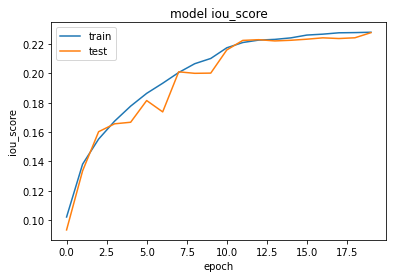

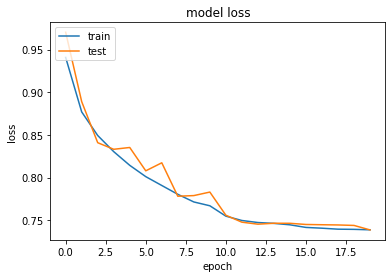

In [37]:
# summarize history for iou_score
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('model iou_score')
plt.ylabel('iou_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Predicting the masks

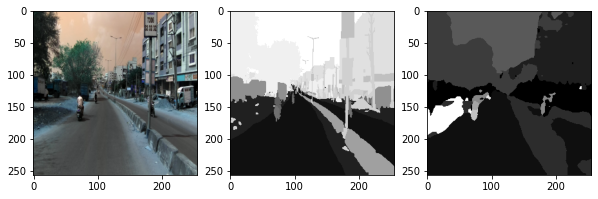

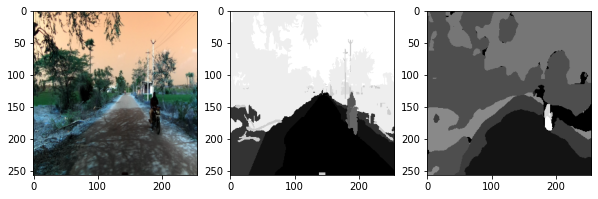

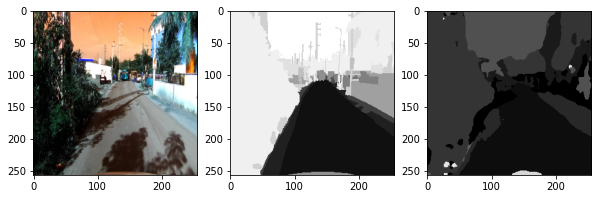

In [36]:
c=3
for p, i in enumerate(X_test):
    if c==0:
      break
    
    #original image

    image = cv2.imread(list(X_test['image'])[p], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256),interpolation = cv2.INTER_AREA) 
    image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #predicted segmentation map

    pred_mask  = model.predict(image1[np.newaxis,:,:,:])
    pred_mask = tf.argmax(pred_mask, axis=-1)

    #original segmentation map

    image_mask = cv2.imread(list(X_test['mask'])[p], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)

    plt.figure(figsize=(10,6))

    plt.subplot(131)

    plt.imshow(image)

    plt.subplot(132)

    plt.imshow(image_mask, cmap='gray')

    plt.subplot(133)

    plt.imshow(pred_mask[0], cmap='gray')

    plt.show()

    c-=1

##### Due to computational limits I have trained these on size 256*256 and for lesser time also. Using bigger size may give better results if trained for longer time.